# "ЭкоФерма". МО для поиска оптимальных параметров отбора коров.

В данной работе моя задача разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. Данная модель поможет заказчику проводить более тщательный отбор, который поможет ферме производить более качественное молоко и все так же выполнять план.

Создадим две прогнозные модели для отбора бурёнок в поголовье:

1. Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
2. Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).
   
Отоберем коров по двум критериям:
+ средний удой за год — не менее 6000 килограммов;
+ молоко должно быть вкусным.

Предоставлены три файла
+ Файл `ferma_main.csv` содержит данные о стаде фермера на текущий момент
+ Файл `ferma_dad.csv` хранит имя папы каждой коровы в стаде фермера
+ Файл `cow_buy.csv` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой

План работы:
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Корреляционный анализ
5. Обучение модели линейной регрессии
6. Обучение модели логистической регрессии
7. Итоговые выводы

## Загрузка данных

In [1]:
!pip install scikit-learn==1.6.1

     |████████████████████████████████| 13.5 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 74.1 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


### 1.1 Импорт библиотек

In [2]:
import pandas  as pd
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats    

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, 
                                   OneHotEncoder
                                  )
from sklearn.linear_model import (LinearRegression, 
                                  LogisticRegression
                                 )
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             mean_absolute_error, 
                             mean_squared_error,
                             precision_score,
                             recall_score,
                             r2_score
                            )

### 1.2 Чтение данных

Прочитаем данные о стаде фермера и посмотрим первые 10 позиций датафрейма

In [3]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';')

In [4]:
ferma_main.head(10)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет
5,6,5254,"12,7",1806,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,13","3,078",вкусно,менее_2_лет
6,7,5910,"13,2",1792,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,48","3,077",вкусно,более_2_лет
7,8,6179,"14,7",1806,"0,93",Вис Бик Айдиал,Равнинные,Айдиал,"3,55","3,076",вкусно,более_2_лет
8,9,6783,"14,2",1918,"0,94",РефлешнСоверинг,Холмистое,Айдиал,"3,71","3,077",вкусно,более_2_лет
9,10,5339,"13,4",1791,"0,895",Вис Бик Айдиал,Холмистое,Соверин,"3,13","3,075",вкусно,менее_2_лет


Проделаем то же самое с двумя другими файлами

In [5]:
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
ferma_dad.head(10)

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
5,6,Барин
6,7,Соловчик
7,8,Геркулес
8,9,Буйный
9,10,Барин


In [6]:
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';')
cow_buy.head(10)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,"3,63","3,053",менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,57","3,079",более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,079",менее_2_лет


### 1.3 Изучение данных

Изучим датафрейм `ferma_main`

In [7]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

Таблица `ferma_main.csv` содержит заявленные данные:
+ `id` — уникальный идентификатор коровы.
+ `Удой, кг` — масса молока, которую корова даёт в год (в килограммах).
+ `ЭКЕ (Энергетическая кормовая единица)` — показатель питательности корма коровы.
+ `Сырой протеин, г` — содержание сырого протеина в корме (в граммах).
+ `СПО` (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
+ `Порода` — порода коровы.
+ `Тип пастбища` — ландшафт лугов, на которых паслась корова.
+ `порода папы_быка` — порода папы коровы.
+ `Жирность,%` — содержание жиров в молоке (в процентах).
+ `Белок,%` — содержание белков в молоке (в процентах).
+ `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (`вкусно`, `не вкусно`).
+ `Возраст` — возраст коровы, бинарный признак (`менее_2_лет`, `более_2_лет`)

В таблице отсутствуют пропуски, но строки таблицы имеют нестандартное обозначение. 

In [8]:
ferma_main.columns

Index(['id', 'Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)',
       'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)', 'Порода',
       'Тип пастбища', 'порода папы_быка', 'Жирность,%', 'Белок,%',
       'Вкус молока', 'Возраст'],
      dtype='object')

In [9]:
ferma_main.rename(columns={
    'id': 'id',
    'Удой, кг': 'yield_kg',
    'ЭКЕ (Энергетическая кормовая единица)': 'energy_feed_unit',
    'Сырой протеин, г': 'crude_protein_g',
    'СПО (Сахаро-протеиновое соотношение)': 'sugar_protein_ratio',
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'sire_breed',
    'Жирность,%': 'fat_percent',
    'Белок,%': 'protein_percent',
    'Вкус молока': 'milk_flavor',
    'Возраст': 'age'
}, inplace=True)

In [10]:
ferma_main.columns

Index(['id', 'yield_kg', 'energy_feed_unit', 'crude_protein_g',
       'sugar_protein_ratio', 'breed', 'pasture_type', 'sire_breed',
       'fat_percent', 'protein_percent', 'milk_flavor', 'age'],
      dtype='object')

Таблица приведена в нормальный формат. Проделаем те же самые операции для двух других датафреймов

In [11]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Таблица `ferma_dad.csv` содержит заявленные данные:
+ `id` — уникальный идентификатор коровы.
+ `Имя Папы` — имя папы коровы

In [12]:
ferma_dad.rename(columns={
    'id': 'id',
    'Имя Папы': 'dad_name'
}, inplace=True)

In [13]:
ferma_dad.columns

Index(['id', 'dad_name'], dtype='object')

In [14]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


Таблица `cow_buy.csv` содержит заявленные данные:
+ `Порода` — порода коровы.
+ `Тип пастбища` — ландшафт лугов, на которых паслась корова.
+ `порода папы_быка` — порода папы коровы.
+ `Имя_папы` — имя папы коровы.
+ `Текущая_жирность,%` — содержание жиров в молоке (в процентах).
+ `Текущий_уровень_белок,%` — содержание белков в молоке (в процентах).
+ `Возраст` — возраст коровы, бинарный признак (`менее_2_лет`, `более_2_лет`)

В таблице отсутствуют пропуски, строки таблицы имеют нестандартное обозначение, кроме этого наименования столбцов приведем к наименованию столбцов таблицы `ferma_main` для корректной работы алгоритмов машинного обучения.

In [15]:
cow_buy.rename(columns={
    'Порода': 'breed', 
    'Тип пастбища': 'pasture_type', 
    'порода папы_быка': 'sire_breed', 
    'Имя_папы': 'dad_name',
    'Текущая_жирность,%': 'fat_percent', 
    'Текущий_уровень_белок,%': 'protein_percent', 
    'Возраст': 'age'
}, inplace=True)

In [16]:
cow_buy.columns

Index(['breed', 'pasture_type', 'sire_breed', 'dad_name', 'fat_percent',
       'protein_percent', 'age'],
      dtype='object')

**Вывод:**
 
1. Представленные данные соответствуют заявленным
2. Пропуски в данных отсутствуют
3. В таблицах произведена замена названий колонок в соответствии со следующим списком:

+ в DataFreme `ferma_main` 
    + 'id' - 'id',
    + 'Удой, кг' - 'yield_kg',
    + 'ЭКЕ (Энергетическая кормовая единица)' - 'energy_feed_unit',
    + 'Сырой протеин, г' - 'crude_protein_g',
    + 'СПО (Сахаро-протеиновое соотношение)' - 'sugar_protein_ratio',
    + 'Порода' - 'breed',
    + 'Тип пастбища' - 'pasture_type',
    + 'порода папы_быка' - 'sire_breed',
    + 'Жирность,%' - 'fat_percent',
    + 'Белок,%' - 'protein_percent',
    + 'Вкус молока' - 'milk_flavor',
    + 'Возраст' - 'age'
+ в DataFreme `dad_name` 
    + 'id' - 'id',
    + 'Имя Папы' - 'dad_name'
+ в DataFreme `cow_buy` 
    + 'Порода' - 'breed', 
    + 'Тип пастбища' - 'pasture_type', 
    + 'порода папы_быка' - 'sire_breed', 
    + 'Имя_папы' - 'dad_name',
    + 'Текущая_жирность,%' - 'fat_percent', 
    + 'Текущий_уровень_белок,%' - 'protein_percent', 
    + 'Возраст' - 'age'
    
 **Файлы прочитаны, приступаем к их предобработке**

##  Предобработка данных

Начнем с предобработки датафрейма `ferma_main`

In [17]:
print('Явных дубликатов:', ferma_main.duplicated().sum())

Явных дубликатов: 5


In [18]:
ferma_main = ferma_main.drop_duplicates()
print('Явных дубликатов после удаления:', ferma_main.duplicated().sum())

Явных дубликатов после удаления: 0


In [19]:
ferma_main.dtypes

id                      int64
yield_kg                int64
energy_feed_unit       object
crude_protein_g         int64
sugar_protein_ratio    object
breed                  object
pasture_type           object
sire_breed             object
fat_percent            object
protein_percent        object
milk_flavor            object
age                    object
dtype: object

In [20]:
ferma_main['energy_feed_unit'] = ferma_main['energy_feed_unit'].str.replace(',','.')
ferma_main['sugar_protein_ratio'] = ferma_main['sugar_protein_ratio'].str.replace(',','.')
ferma_main['fat_percent'] = ferma_main['fat_percent'].str.replace(',','.')
ferma_main['protein_percent'] = ferma_main['protein_percent'].str.replace(',','.')
ferma_main[['energy_feed_unit', 'sugar_protein_ratio', 'fat_percent', 'protein_percent']] = ferma_main[['energy_feed_unit', 'sugar_protein_ratio', 'fat_percent', 'protein_percent']].astype('float')
ferma_main.dtypes

id                       int64
yield_kg                 int64
energy_feed_unit       float64
crude_protein_g          int64
sugar_protein_ratio    float64
breed                   object
pasture_type            object
sire_breed              object
fat_percent            float64
protein_percent        float64
milk_flavor             object
age                     object
dtype: object

Далее проведем предобработку датафрейма `ferma_dad`

In [21]:
print('Явных дубликатов:', ferma_dad.duplicated().sum())

Явных дубликатов: 0


In [22]:
ferma_dad.dtypes

id           int64
dad_name    object
dtype: object

И, наконец, обработаем `cow_buy`

In [23]:
print('Явных дубликатов:', cow_buy.duplicated().sum())

Явных дубликатов: 4


С учетом того, что эти данные будут использоваться в тестовой выборке, дубликаты оставим без удаления

In [24]:
cow_buy.dtypes

breed              object
pasture_type       object
sire_breed         object
dad_name           object
fat_percent        object
protein_percent    object
age                object
dtype: object

In [25]:
cow_buy['fat_percent'] = cow_buy['fat_percent'].str.replace(',','.')
cow_buy['protein_percent'] = cow_buy['protein_percent'].str.replace(',','.')
cow_buy[['fat_percent', 'protein_percent']] = cow_buy[['fat_percent', 'protein_percent']].astype('float')
cow_buy.dtypes

breed               object
pasture_type        object
sire_breed          object
dad_name            object
fat_percent        float64
protein_percent    float64
age                 object
dtype: object

### 2.2 Анализ данных в столбцах

Сопоставление данных в столбцах `dtype = object` и проверка

In [26]:
print('ferma_main["breed"]', ferma_main['breed'].unique())
print('cow_buy["breed"]', cow_buy['breed'].unique())
print('breed', ferma_main['breed']. isin (cow_buy['breed']). value_counts ())

print('\nferma_main["pasture_type"]', ferma_main['pasture_type'].unique())
print('cow_buy["pasture_type"]', cow_buy['pasture_type'].unique())
ferma_main['pasture_type'] = ferma_main['pasture_type'].str.replace('Равнинные','Равнинное')
cow_buy['pasture_type'] = cow_buy['pasture_type'].str.replace('равнинное','Равнинное')
cow_buy['pasture_type'] = cow_buy['pasture_type'].str.replace('холмистое','Холмистое')
print('pasture_type', ferma_main['pasture_type']. isin (cow_buy['pasture_type']). value_counts ())

print('\nferma_main["sire_breed"]', ferma_main['sire_breed'].unique())
print('cow_buy["sire_breed"]', cow_buy['sire_breed'].unique())
ferma_main['sire_breed'] = ferma_main['sire_breed'].str.replace('Айдиалл','Айдиал')
print('sire_breed', ferma_main['sire_breed']. isin (cow_buy['sire_breed']). value_counts ())

print('\nferma_dad["dad_name"]', ferma_dad['dad_name'].unique())
print('cow_buy["dad_name"]', cow_buy['dad_name'].unique())
print('dad_name', ferma_dad['dad_name']. isin (cow_buy['dad_name']). value_counts ())

print('\nferma_main["age"]', ferma_main['age'].unique())
print('cow_buy["age"]', cow_buy['age'].unique())
print('age', ferma_main['age']. isin (cow_buy['age']). value_counts ())

ferma_main["breed"] ['Вис Бик Айдиал' 'РефлешнСоверинг']
cow_buy["breed"] ['Вис Бик Айдиал' 'РефлешнСоверинг']
breed True    629
Name: breed, dtype: int64

ferma_main["pasture_type"] ['Равнинное' 'Равнинные' 'Холмистое']
cow_buy["pasture_type"] ['холмистое' 'равнинное']
pasture_type True    629
Name: pasture_type, dtype: int64

ferma_main["sire_breed"] ['Айдиал' 'Соверин' 'Айдиалл']
cow_buy["sire_breed"] ['Айдиал' 'Соверин']
sire_breed True    629
Name: sire_breed, dtype: int64

ferma_dad["dad_name"] ['Буйный' 'Соловчик' 'Барин' 'Геркулес']
cow_buy["dad_name"] ['Геркулес' 'Буйный' 'Барин' 'Соловчик']
dad_name True    629
Name: dad_name, dtype: int64

ferma_main["age"] ['более_2_лет' 'менее_2_лет']
cow_buy["age"] ['более_2_лет' 'менее_2_лет']
age True    629
Name: age, dtype: int64


**Вывод:**
    
1. Проведен поиск явных дубликатов
+ в DataFreme `ferma_main` удалено 5 явных дубликатов
+ в DataFreme `dad_name` явных дубликатов не обнаружено
+ в DataFreme `cow_buy` удалено 4 явных дубликатов

2. В таблицах произведено преобразование типов
3. Проведено сопоставление данных в столбцах `dtype = object` и приведение их к единообразию

## Исследовательский анализ данных

In [27]:
ferma_main.describe()

,id,yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,fat_percent,protein_percent
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


Описательная статискика указывает на содержание в столбце `yield_kg` выброса значительно превышающего медианное значение и третий квартиль Скорее всего это строка с итогом или с ошибкой ввода данных.

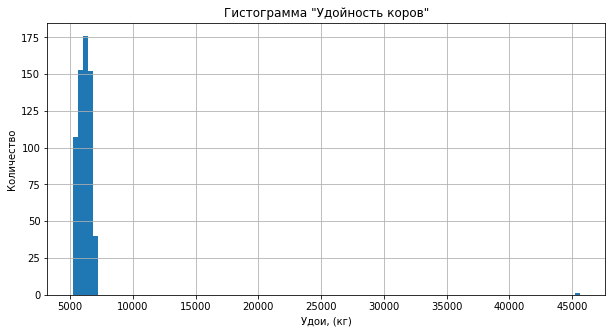

In [28]:
(
    ferma_main['yield_kg']
    .plot(kind='hist', bins=100, grid=True, figsize=(10, 5))
)
plt.title('Гистограмма "Удойность коров"')
plt.xlabel('Удои, (кг)')
plt.ylabel('Количество')
plt.show()

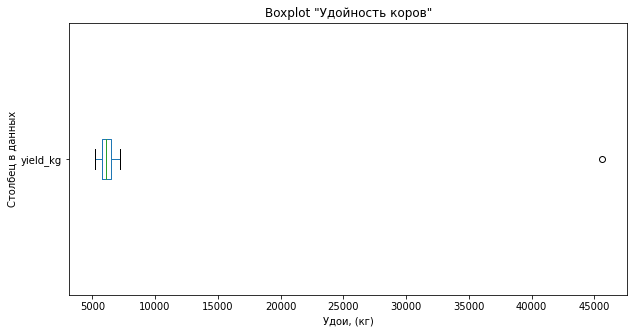

In [29]:
(
    ferma_main['yield_kg']
    .plot(kind='box', vert=False, figsize=(10, 5))
)
plt.title('Boxplot "Удойность коров"')
plt.xlabel('Удои, (кг)')
plt.ylabel('Столбец в данных')
plt.show()

In [30]:
ferma_main[ferma_main['yield_kg']==ferma_main['yield_kg'].max()]

,id,yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,fat_percent,protein_percent,milk_flavor,age
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,Холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет


Запишем медианное значение

In [31]:
ferma_main.loc[16,'yield_kg'] = ferma_main['yield_kg'].median()
ferma_main.iloc [[16]]

,id,yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,fat_percent,protein_percent,milk_flavor,age
16,17,6133.0,11.5,1675,0.93,Вис Бик Айдиал,Холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет


In [32]:
ferma_main = ferma_main.drop (index=16)
ferma_main['yield_kg'].describe()

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: yield_kg, dtype: float64

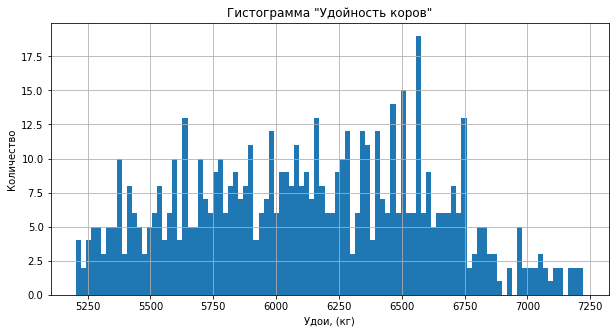

In [33]:
(
    ferma_main['yield_kg']
    .plot(kind='hist', bins=100, grid=True, figsize=(10, 5))
)
plt.title('Гистограмма "Удойность коров"')
plt.xlabel('Удои, (кг)')
plt.ylabel('Количество')
plt.show()


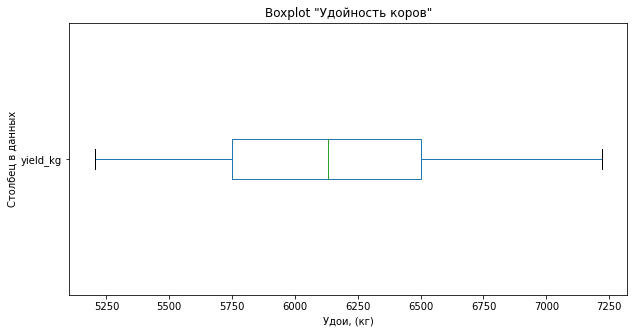

In [34]:
(
    ferma_main['yield_kg']
    .plot(kind='box', vert=False, figsize=(10, 5))
)
plt.title('Boxplot "Удойность коров"')
plt.xlabel('Удои, (кг)')
plt.ylabel('Столбец в данных')
plt.show()

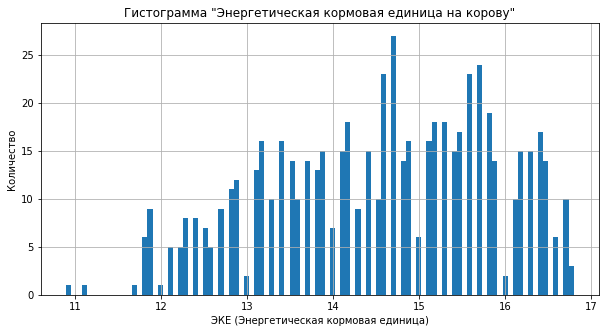

In [35]:
ax = (
    ferma_main['energy_feed_unit']
    .plot(kind='hist', bins=100, grid=True, figsize=(10, 5))
)

plt.title('Гистограмма "Энергетическая кормовая единица на корову"')
plt.xlabel('ЭКЕ (Энергетическая кормовая единица)')
plt.ylabel('Количество')
plt.show()

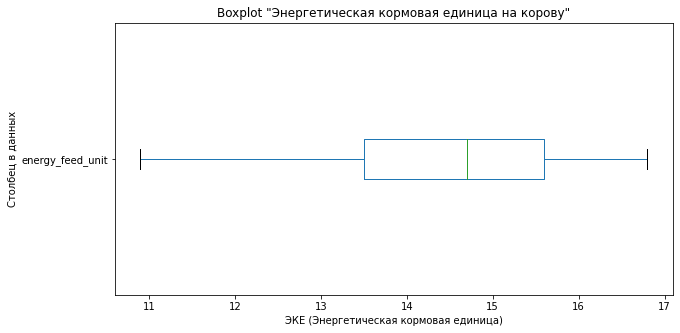

In [36]:
(
    ferma_main['energy_feed_unit']
    .plot(kind='box', vert=False, figsize=(10, 5))
)
plt.title('Boxplot "Энергетическая кормовая единица на корову"')
plt.xlabel('ЭКЕ (Энергетическая кормовая единица)')
plt.ylabel('Столбец в данных')
plt.show()

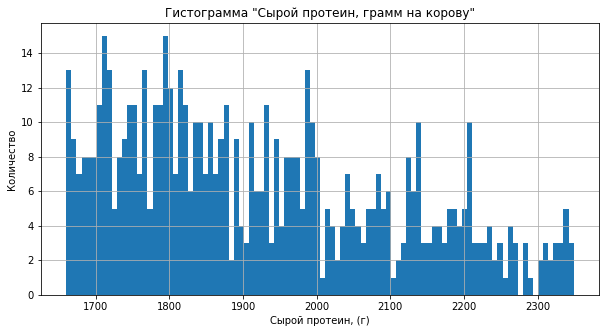

In [37]:
(
    ferma_main['crude_protein_g']
    .plot(kind='hist', bins=100, grid=True, figsize=(10, 5))
)
plt.title('Гистограмма "Сырой протеин, грамм на корову"')
plt.xlabel('Сырой протеин, (г)')
plt.ylabel('Количество')
plt.show()

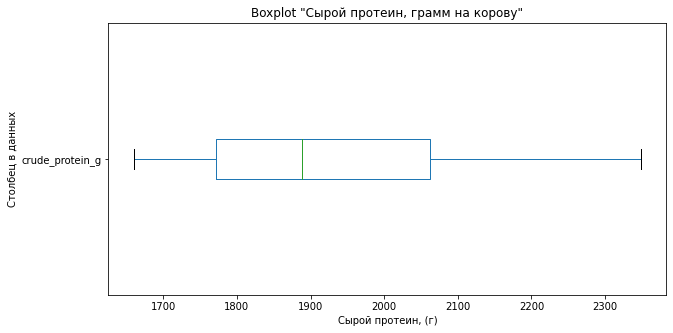

In [38]:
(
    ferma_main['crude_protein_g']
    .plot(kind='box', vert=False, figsize=(10, 5))
)
plt.title('Boxplot "Сырой протеин, грамм на корову"')
plt.xlabel('Сырой протеин, (г)')
plt.ylabel('Столбец в данных')
plt.show()

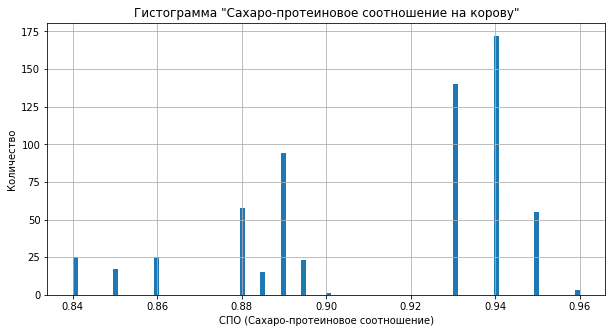

In [39]:
(
    ferma_main['sugar_protein_ratio']
    .plot(kind='hist', bins=100, grid=True, figsize=(10, 5))
)
plt.title('Гистограмма "Сахаро-протеиновое соотношение на корову"')
plt.xlabel('СПО (Сахаро-протеиновое соотношение)')
plt.ylabel('Количество')
plt.show()

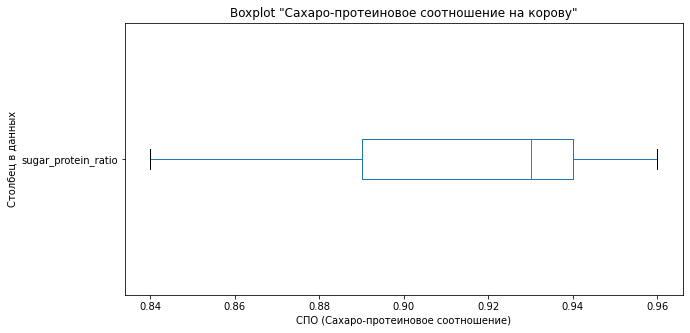

In [40]:
(
    ferma_main['sugar_protein_ratio']
    .plot(kind='box', vert=False, figsize=(10, 5))
)
plt.title('Boxplot "Сахаро-протеиновое соотношение на корову"')
plt.xlabel('СПО (Сахаро-протеиновое соотношение)')
plt.ylabel('Столбец в данных')
plt.show()

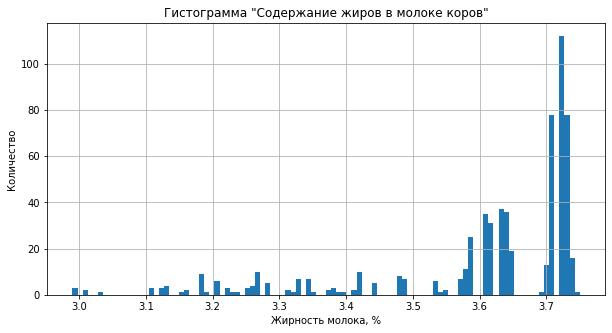

In [41]:
(
    ferma_main['fat_percent']
    .plot(kind='hist', bins=100, grid=True, figsize=(10, 5))
)
plt.title('Гистограмма "Содержание жиров в молоке коров"')
plt.xlabel('Жирность молока, %')
plt.ylabel('Количество')
plt.show()

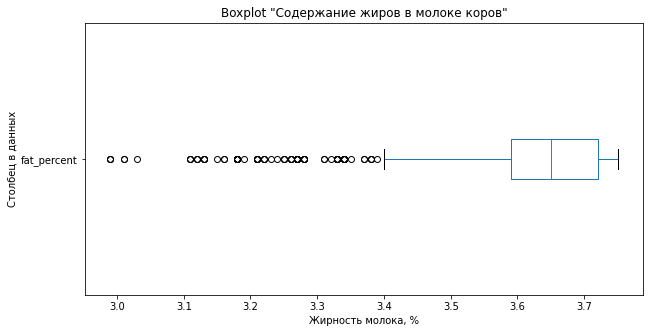

In [42]:
(
    ferma_main['fat_percent']
    .plot(kind='box', vert=False, figsize=(10, 5))
)
plt.title('Boxplot "Содержание жиров в молоке коров"')
plt.xlabel('Жирность молока, %')
plt.ylabel('Столбец в данных')
plt.show()

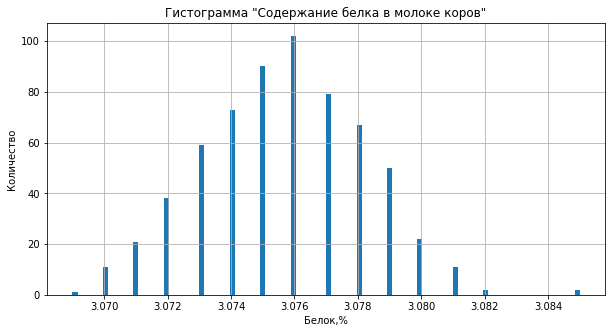

In [43]:
(
    ferma_main['protein_percent']
    .plot(kind='hist', bins=100, grid=True, figsize=(10, 5))
)
plt.title('Гистограмма "Содержание белка в молоке коров"')
plt.xlabel('Белок,%')
plt.ylabel('Количество')
plt.show()

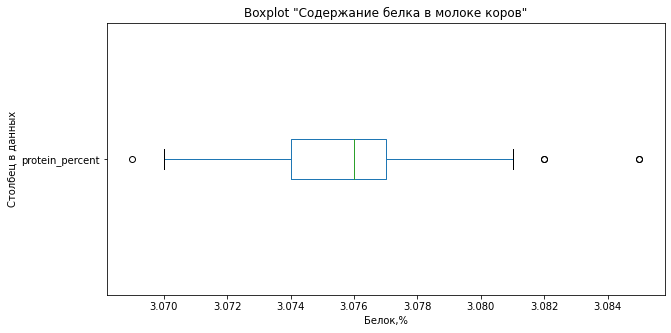

In [44]:
(
    ferma_main['protein_percent']
    .plot(kind='box', vert=False, figsize=(10, 5))
)
plt.title('Boxplot "Содержание белка в молоке коров"')
plt.xlabel('Белок,%')
plt.ylabel('Столбец в данных')
plt.show()

Сводная статистика для строковых значений

In [45]:
ferma_main.describe(include='object')

,breed,pasture_type,sire_breed,milk_flavor,age
count,628,628,628,628,628
unique,2,2,2,2,2
top,Вис Бик Айдиал,Холмистое,Айдиал,вкусно,более_2_лет
freq,372,350,317,370,518


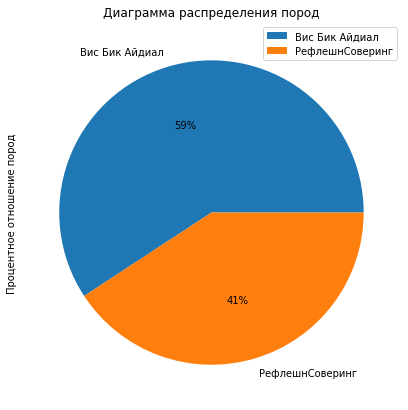

In [46]:
(
ferma_main
    .pivot_table(index='breed',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,7), label='Процентное отношение пород')
)
plt.title('Диаграмма распределения пород')
plt.show()

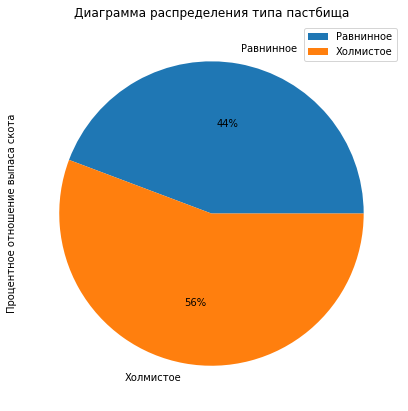

In [47]:
(
ferma_main
    .pivot_table(index='pasture_type',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,7), label='Процентное отношение выпаса скота')
)
plt.title('Диаграмма распределения типа пастбища')
plt.show()

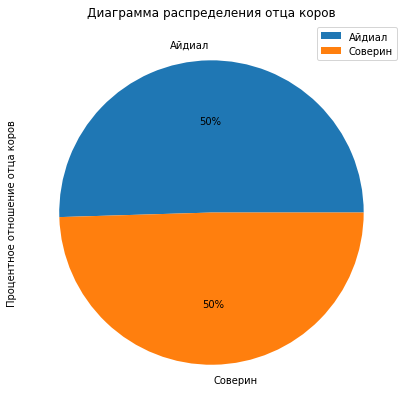

In [48]:
(
ferma_main
    .pivot_table(index='sire_breed',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,7), label='Процентное отношение отца коров')
)
plt.title('Диаграмма распределения отца коров')
plt.show()

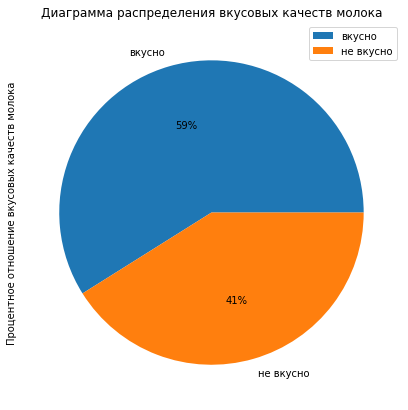

In [49]:
(
ferma_main
    .pivot_table(index='milk_flavor',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,7), label='Процентное отношение вкусовых качеств молока')
)
plt.title('Диаграмма распределения вкусовых качеств молока')
plt.show()

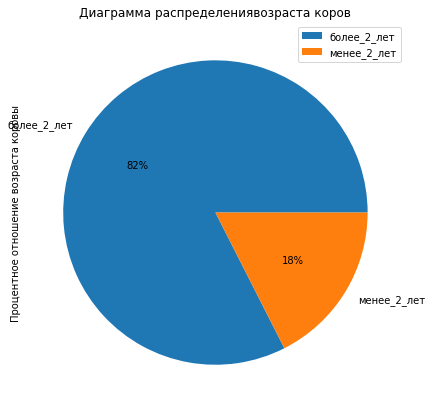

In [50]:
(
ferma_main
    .pivot_table(index='age',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,7), label='Процентное отношение возраста коровы')
)
plt.title('Диаграмма распределениявозраста коров')
plt.show()

**Вывод:**

В процессе проведения анализа данных
1. Вызвали описательную статистику и проанализировали её выявив выброс в столбце `ferma_main['yield_kg']` выброса значительно превышающего медианное значение и третий квартиль Скорее всего это строка с итогом или с ошибкой ввода данных.
2. Проверили на гистограмме и boxplot приняли решение заменить значение на медианное
3. Построили гистограммы и boxplot для каждого числового признака, для строковых значений построили диаграммы распределения выявили:
+ По числовым значениям:
    + `ferma_main['yield_kg']` - удой - может и носит нормальное распределение но дисперсия слишком большая, выбросов нет
    + `ferma_main['energy_feed_unit']` - ЭКЕ - прослеживается нормальность распределения, дисперсия велика, выбросов нет
    + `ferma_main['crude_protein_g']` - сырой протеин - не прослеживается нормальность распределения, дисперсия велика, выбросов нет
    + `ferma_main['sugar_protein_ratio']` - СПО - не носит нормальность распределения, скорее линейная зависимость с пропусками результатов, выбросов нет
    + `ferma_main['fat_percent']` - жирность - Не прослеживается нормальность распределения, скорее степенной функции с возрастанием, присутствует большое количество выбросов, возможно это молодые или стельные коровы
    + `ferma_main['protein_percent']` - протеин -  Прослеживается явное нормальное рампределение, содержит три выброса, возможно это реальные отклонения и их стоит отсеить.
+ По строковым значениям
    + `ferma_main['breed']` преобладает порода Вис Бик Айдиал 59 %
    + `ferma_main['pasture_type']` преобладает Холмистый выпас 56 %
    + `ferma_main['sire_breed']` порода отца коров распределена поровну 50/50 %
    + `ferma_main['milk_flavor']` преобладает вкусное молоко 59 %
    + `ferma_main['age']` преобладает количество коров с возрастом более 2 лет 82 %
4. Для улучшения данных можно:
+ дополнительно запросить статистику у фермера
+ сделать срез по столбцам с выбросами `fat_percent`, `protein_percent` при прогнозировании вкусности молока

## Корреляционный анализ

Объединим таблицы `ferma_main` и `ferma_dad` по `id`

In [51]:
ferma_main = pd.merge(ferma_main, ferma_dad, on='id', how='left')
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 627
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   628 non-null    int64  
 1   yield_kg             628 non-null    float64
 2   energy_feed_unit     628 non-null    float64
 3   crude_protein_g      628 non-null    int64  
 4   sugar_protein_ratio  628 non-null    float64
 5   breed                628 non-null    object 
 6   pasture_type         628 non-null    object 
 7   sire_breed           628 non-null    object 
 8   fat_percent          628 non-null    float64
 9   protein_percent      628 non-null    float64
 10  milk_flavor          628 non-null    object 
 11  age                  628 non-null    object 
 12  dad_name             628 non-null    object 
dtypes: float64(5), int64(2), object(6)
memory usage: 68.7+ KB


### 4.1 Расчет корреляции между количественными значениями

In [52]:
ferma_main

,id,yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,fat_percent,protein_percent,milk_flavor,age,dad_name
0,1,5863.0,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529.0,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810.0,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895.0,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302.0,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625,6812.0,15.4,1964,0.940,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет,Буйный
624,626,5513.0,12.9,1700,0.880,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет,Барин
625,627,5970.0,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет,Барин
626,628,5746.0,13.8,1994,0.890,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,вкусно,более_2_лет,Барин


<AxesSubplot:>

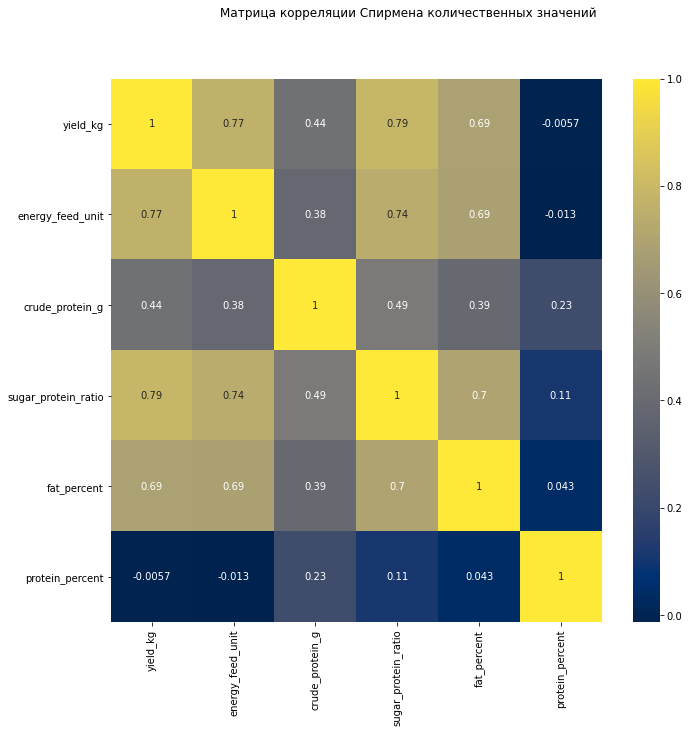

In [53]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции Спирмена количественных значений')
sns.heatmap(ferma_main.drop('id', axis=1).select_dtypes(include=['int', 'float']).corr(method="spearman"), annot=True, cmap='cividis')

Корреляция Спирмена (непараметрическая мера оценивающая монотонность связи) количественных значений по шкале Чеддока указывает на:
+ высокую связь между удоями и СПО corr = 0,79
+ высокую связь между удоями и ЭКЕ corr = 0,77

+ средняя связь между удоями и жирностью corr = 0,69, но по факту это результат удоя и рассматривать его нецелесообразно,  в задаче отсутствует цель спрогнозировать жирность молока, но вот его вкус может зависеть от жирности.

Между входными параметрами отсутствует связь выше 0,9 следовательно при обучении модели учитывать мультиколлинеарность не надо.

### 4.2 Диаграмма рассеяния

In [54]:
x=['yield_kg', 'energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'fat_percent', 'protein_percent']
y=['yield_kg']

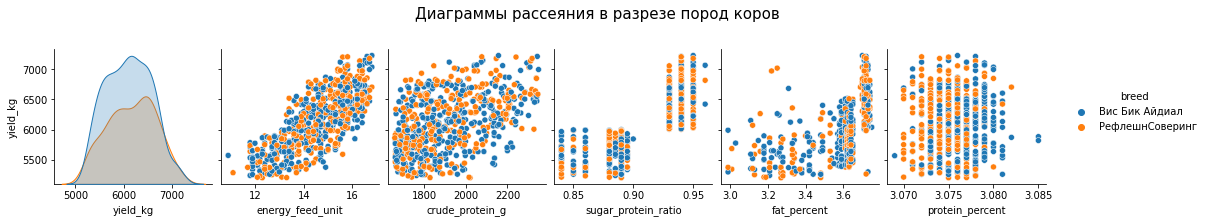

In [55]:
g = sns.pairplot(ferma_main, hue="breed", x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния в разрезе пород коров", y=1.2, fontsize=15)
plt.show()

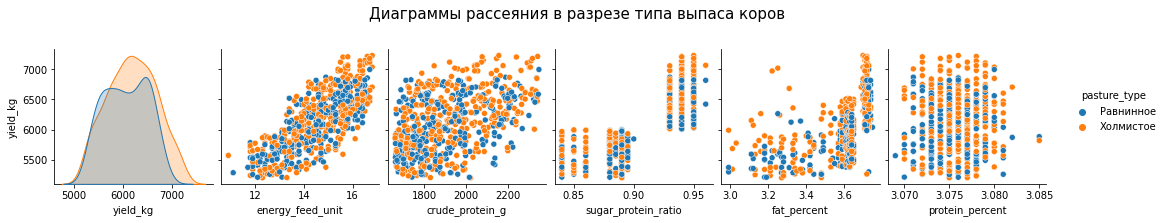

In [56]:
g = sns.pairplot(ferma_main, hue="pasture_type", x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния в разрезе типа выпаса коров", y=1.2, fontsize=15)
plt.show()

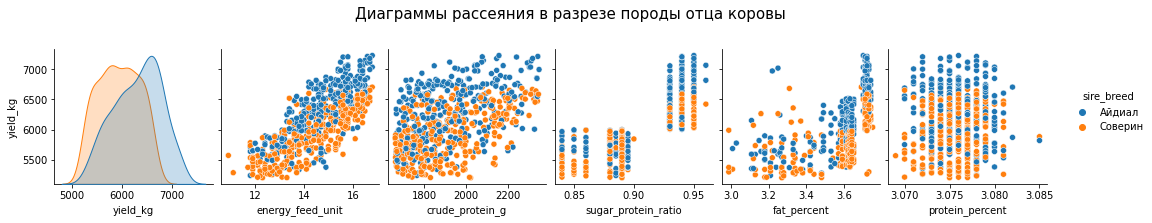

In [57]:
g = sns.pairplot(ferma_main, hue="sire_breed", x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния в разрезе породы отца коровы", y=1.2, fontsize=15)
plt.show()

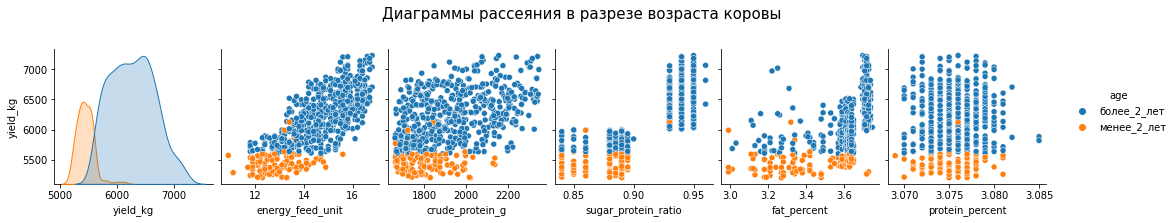

In [58]:
g = sns.pairplot(ferma_main, hue="age", x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния в разрезе возраста коровы", y=1.2, fontsize=15)
plt.show()

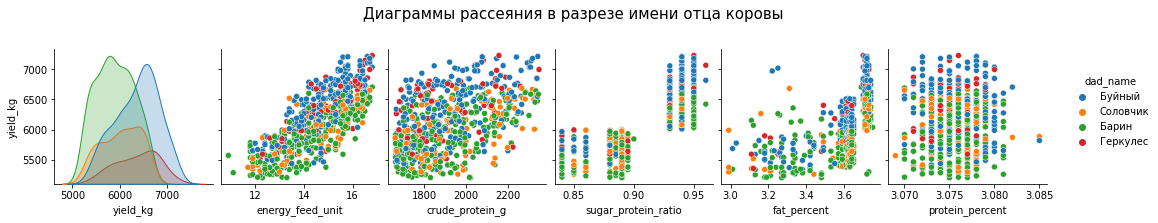

In [59]:
g = sns.pairplot(ferma_main, hue="dad_name", x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния в разрезе имени отца коровы", y=1.2, fontsize=15)
plt.show()

Далее построим уточненные диаграммы рассеяния

In [60]:
df1 = ferma_main[ferma_main['breed'] == 'Вис Бик Айдиал']
df2 = ferma_main[ferma_main['breed'] == 'РефлешнСоверинг']

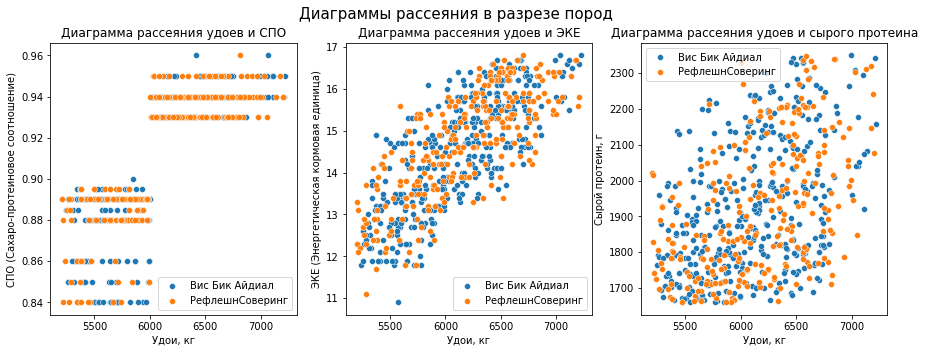

In [61]:
plt.figure(figsize=[15, 5])
plt.suptitle('Диаграммы рассеяния в разрезе пород', fontsize=15)

plt.subplot(1, 3, 1)
sns.scatterplot(data=df1, x='yield_kg', y='sugar_protein_ratio', label = 'Вис Бик Айдиал')
sns.scatterplot(data=df2, x='yield_kg', y='sugar_protein_ratio', label = 'РефлешнСоверинг');
plt.title('Диаграмма рассеяния удоев и СПО')
plt.xlabel('Удои, кг')
plt.ylabel('СПО (Сахаро-протеиновое соотношение)')

plt.subplot(1, 3, 2)
sns.scatterplot(data=df1, x='yield_kg', y='energy_feed_unit', label = 'Вис Бик Айдиал')
sns.scatterplot(data=df2, x='yield_kg', y='energy_feed_unit', label = 'РефлешнСоверинг');
plt.title('Диаграмма рассеяния удоев и ЭКЕ')
plt.xlabel('Удои, кг')
plt.ylabel('ЭКЕ (Энергетическая кормовая единица)')

plt.subplot(1, 3, 3)
sns.scatterplot(data=df1, x='yield_kg', y='crude_protein_g', label = 'Вис Бик Айдиал')
sns.scatterplot(data=df2, x='yield_kg', y='crude_protein_g', label = 'РефлешнСоверинг');
plt.title('Диаграмма рассеяния удоев и сырого протеина')
plt.xlabel('Удои, кг')
plt.ylabel('Сырой протеин, г')

plt.show()

In [62]:
df1 = ferma_main[ferma_main['pasture_type'] == 'Равнинное']
df2 = ferma_main[ferma_main['pasture_type'] == 'Холмистое']

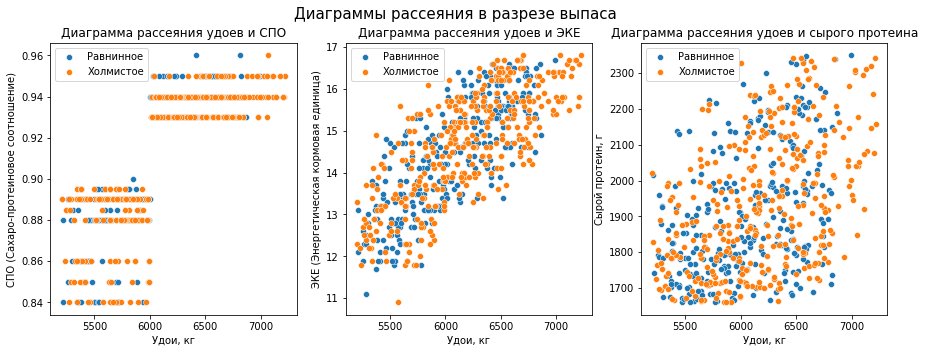

In [63]:
plt.figure(figsize=[15, 5])
plt.suptitle('Диаграммы рассеяния в разрезе выпаса', fontsize=15)

plt.subplot(1, 3, 1)
sns.scatterplot(data=df1, x='yield_kg', y='sugar_protein_ratio', label = 'Равнинное')
sns.scatterplot(data=df2, x='yield_kg', y='sugar_protein_ratio', label = 'Холмистое');
plt.title('Диаграмма рассеяния удоев и СПО')
plt.xlabel('Удои, кг')
plt.ylabel('СПО (Сахаро-протеиновое соотношение)')

plt.subplot(1, 3, 2)
sns.scatterplot(data=df1, x='yield_kg', y='energy_feed_unit', label = 'Равнинное')
sns.scatterplot(data=df2, x='yield_kg', y='energy_feed_unit', label = 'Холмистое');
plt.title('Диаграмма рассеяния удоев и ЭКЕ')
plt.xlabel('Удои, кг')
plt.ylabel('ЭКЕ (Энергетическая кормовая единица)')

plt.subplot(1, 3, 3)
sns.scatterplot(data=df1, x='yield_kg', y='crude_protein_g', label = 'Равнинное')
sns.scatterplot(data=df2, x='yield_kg', y='crude_protein_g', label = 'Холмистое');
plt.title('Диаграмма рассеяния удоев и сырого протеина')
plt.xlabel('Удои, кг')
plt.ylabel('Сырой протеин, г')

plt.show()

In [64]:
df1 = ferma_main[ferma_main['sire_breed'] == 'Айдиал']
df2 = ferma_main[ferma_main['sire_breed'] == 'Соверин']

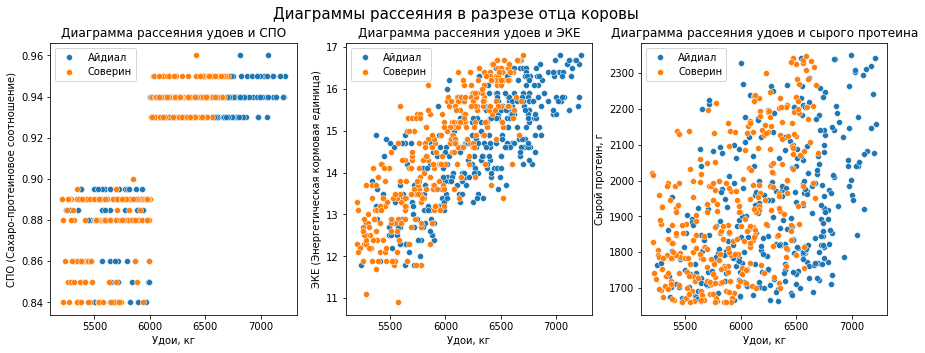

In [65]:
plt.figure(figsize=[15, 5])
plt.suptitle('Диаграммы рассеяния в разрезе отца коровы', fontsize=15)

plt.subplot(1, 3, 1)
sns.scatterplot(data=df1, x='yield_kg', y='sugar_protein_ratio', label = 'Айдиал')
sns.scatterplot(data=df2, x='yield_kg', y='sugar_protein_ratio', label = 'Соверин');
plt.title('Диаграмма рассеяния удоев и СПО')
plt.xlabel('Удои, кг')
plt.ylabel('СПО (Сахаро-протеиновое соотношение)')

plt.subplot(1, 3, 2)
sns.scatterplot(data=df1, x='yield_kg', y='energy_feed_unit', label = 'Айдиал')
sns.scatterplot(data=df2, x='yield_kg', y='energy_feed_unit', label = 'Соверин');
plt.title('Диаграмма рассеяния удоев и ЭКЕ')
plt.xlabel('Удои, кг')
plt.ylabel('ЭКЕ (Энергетическая кормовая единица)')

plt.subplot(1, 3, 3)
sns.scatterplot(data=df1, x='yield_kg', y='crude_protein_g', label = 'Айдиал')
sns.scatterplot(data=df2, x='yield_kg', y='crude_protein_g', label = 'Соверин');
plt.title('Диаграмма рассеяния удоев и сырого протеина')
plt.xlabel('Удои, кг')
plt.ylabel('Сырой протеин, г')

plt.show()

In [66]:
df1 = ferma_main[ferma_main['age'] == 'менее_2_лет']
df2 = ferma_main[ferma_main['age'] == 'более_2_лет']

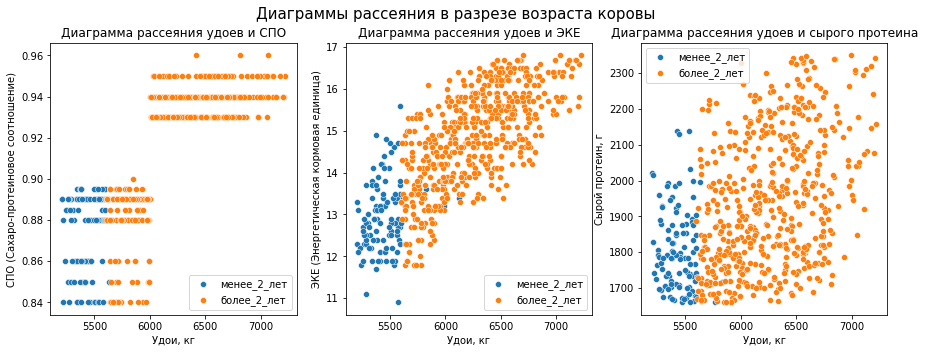

In [67]:
plt.figure(figsize=[15, 5])
plt.suptitle('Диаграммы рассеяния в разрезе возраста коровы', fontsize=15)

plt.subplot(1, 3, 1)
sns.scatterplot(data=df1, x='yield_kg', y='sugar_protein_ratio', label = 'менее_2_лет')
sns.scatterplot(data=df2, x='yield_kg', y='sugar_protein_ratio', label = 'более_2_лет');
plt.title('Диаграмма рассеяния удоев и СПО')
plt.xlabel('Удои, кг')
plt.ylabel('СПО (Сахаро-протеиновое соотношение)')

plt.subplot(1, 3, 2)
sns.scatterplot(data=df1, x='yield_kg', y='energy_feed_unit', label = 'менее_2_лет')
sns.scatterplot(data=df2, x='yield_kg', y='energy_feed_unit', label = 'более_2_лет');
plt.title('Диаграмма рассеяния удоев и ЭКЕ')
plt.xlabel('Удои, кг')
plt.ylabel('ЭКЕ (Энергетическая кормовая единица)')

plt.subplot(1, 3, 3)
sns.scatterplot(data=df1, x='yield_kg', y='crude_protein_g', label = 'менее_2_лет')
sns.scatterplot(data=df2, x='yield_kg', y='crude_protein_g', label = 'более_2_лет');
plt.title('Диаграмма рассеяния удоев и сырого протеина')
plt.xlabel('Удои, кг')
plt.ylabel('Сырой протеин, г')

plt.show()

In [68]:
ferma_main['dad_name'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

In [69]:
df1 = ferma_main[ferma_main['dad_name'] == 'Буйный']
df2 = ferma_main[ferma_main['dad_name'] == 'Соловчик']
df3 = ferma_main[ferma_main['dad_name'] == 'Барин']
df4 = ferma_main[ferma_main['dad_name'] == 'Геркулес']

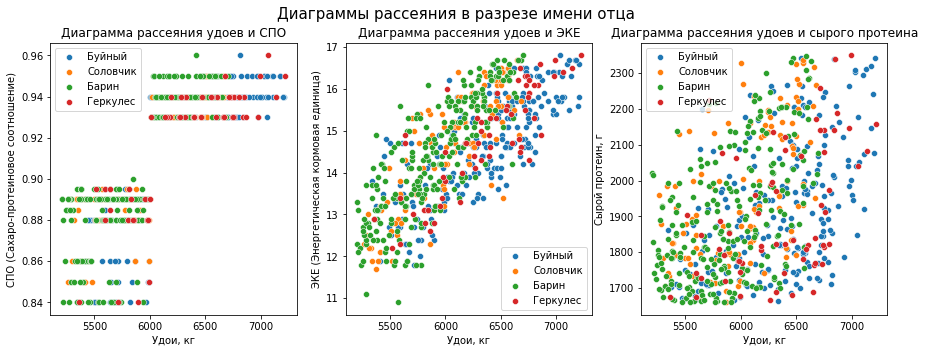

In [70]:
plt.figure(figsize=[15, 5])
plt.suptitle('Диаграммы рассеяния в разрезе имени отца', fontsize=15)

plt.subplot(1, 3, 1)
sns.scatterplot(data=df1, x='yield_kg', y='sugar_protein_ratio', label = 'Буйный')
sns.scatterplot(data=df2, x='yield_kg', y='sugar_protein_ratio', label = 'Соловчик')
sns.scatterplot(data=df3, x='yield_kg', y='sugar_protein_ratio', label = 'Барин')
sns.scatterplot(data=df4, x='yield_kg', y='sugar_protein_ratio', label = 'Геркулес')
plt.title('Диаграмма рассеяния удоев и СПО')
plt.xlabel('Удои, кг')
plt.ylabel('СПО (Сахаро-протеиновое соотношение)')

plt.subplot(1, 3, 2)
sns.scatterplot(data=df1, x='yield_kg', y='energy_feed_unit', label = 'Буйный')
sns.scatterplot(data=df2, x='yield_kg', y='energy_feed_unit', label = 'Соловчик')
sns.scatterplot(data=df3, x='yield_kg', y='energy_feed_unit', label = 'Барин')
sns.scatterplot(data=df4, x='yield_kg', y='energy_feed_unit', label = 'Геркулес')
plt.title('Диаграмма рассеяния удоев и ЭКЕ')
plt.xlabel('Удои, кг')
plt.ylabel('ЭКЕ (Энергетическая кормовая единица)')

plt.subplot(1, 3, 3)
sns.scatterplot(data=df1, x='yield_kg', y='crude_protein_g', label = 'Буйный')
sns.scatterplot(data=df2, x='yield_kg', y='crude_protein_g', label = 'Соловчик')
sns.scatterplot(data=df3, x='yield_kg', y='crude_protein_g', label = 'Барин')
sns.scatterplot(data=df4, x='yield_kg', y='crude_protein_g', label = 'Геркулес')
plt.title('Диаграмма рассеяния удоев и сырого протеина')
plt.xlabel('Удои, кг')
plt.ylabel('Сырой протеин, г')

plt.show()

**Вывод:**

В процессе проведения корреляционного анализа данных можно заметить, что:
1. Молодые коровы до 2 лет содержатся на кормах в которых малое сахоро - протеиновое отношение мало (до 0,90 единиц). Прослеживается четкая граница их удойности примерно до 5300 килограмм молока, с возрастом удой коров увеличивается, но для дальнейшего роста удоя необходимо увеличивать СПО. Коровы переведенные на такой корм дают увеличивают удои свыше 6000 кг.
2. У коров отцом которых был "Айдиал" при переходе на корм с показателем СПО > 0.92 единицы прослеживаются большие удои по сравнению с другой группой, при этом в сравнении пород такой явной зависимости не прослеживается.
3. По ЭКЕ и удою у среднее между линейной и квадратичной зависимостью так как прослеживается небольшой изгиб на диаграмме рассеяния входных данных. Чтобы модель могла корректно учитывать признак, предлагается взять квадрат признака.
3. Корреляция Спирмена (непараметрическая мера оценивающая монотонность связи) количественных значений по шкале Чеддока указывает на:
+ высокую связь между удоями и СПО corr = 0,79
+ высокую связь между удоями и ЭКЕ corr = 0,77

+ средняя связь между удоями и жирностью corr = 0,69, но по факту это результат удоя и рассматривать его нецелесообразно,  в задаче отсутствует цель спрогнозировать жирность молока, но вот его вкус может зависеть от жирности.

между входными параметрами отсутствует связь выше 0,9 следовательно при обучении модели учитывать мультиколлинеарность не надо.

## Обучение модели линейной регрессии

### 5.1 Первая модель линейной регрессии

In [71]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 627
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   628 non-null    int64  
 1   yield_kg             628 non-null    float64
 2   energy_feed_unit     628 non-null    float64
 3   crude_protein_g      628 non-null    int64  
 4   sugar_protein_ratio  628 non-null    float64
 5   breed                628 non-null    object 
 6   pasture_type         628 non-null    object 
 7   sire_breed           628 non-null    object 
 8   fat_percent          628 non-null    float64
 9   protein_percent      628 non-null    float64
 10  milk_flavor          628 non-null    object 
 11  age                  628 non-null    object 
 12  dad_name             628 non-null    object 
dtypes: float64(5), int64(2), object(6)
memory usage: 68.7+ KB


In [72]:
RANDOM_STATE = 42

cat_col_names = ['breed',
                 'pasture_type',
                 'sire_breed',
                 'age',
                ]
num_col_names = ['energy_feed_unit',
                 'crude_protein_g',
                 'sugar_protein_ratio'
                ]
X = ferma_main.drop('yield_kg', axis=1)
y = ferma_main['yield_kg']
X = X.drop(['id', 'fat_percent', 'protein_percent', 'milk_flavor'], axis=1)
X.head(10)

,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,age,dad_name
0,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет,Буйный
1,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,Соловчик
2,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,более_2_лет,Барин
3,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет,Буйный
4,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,Барин
5,12.7,1806,0.885,РефлешнСоверинг,Холмистое,Соверин,менее_2_лет,Барин
6,13.2,1792,0.885,Вис Бик Айдиал,Равнинное,Соверин,более_2_лет,Соловчик
7,14.7,1806,0.930,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет,Геркулес
8,14.2,1918,0.940,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет,Буйный
9,13.4,1791,0.895,Вис Бик Айдиал,Холмистое,Соверин,менее_2_лет,Барин


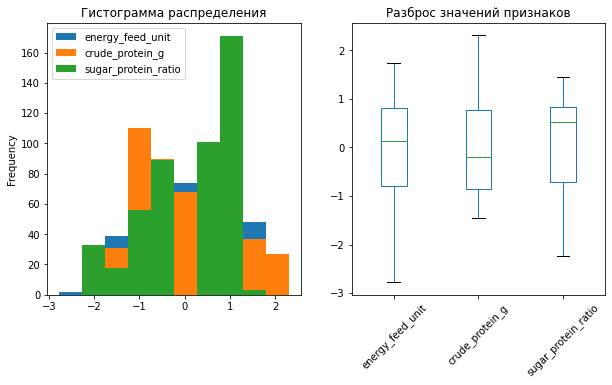

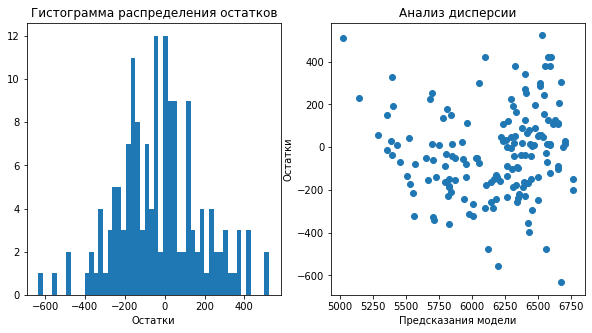

R^2 LinearRegression = 0.78 ((+∞ до 1), lim = 1) 
RMSE LinearRegression  = 209.49 ((0 до +∞), lim = 0)
MSE LinearRegression  = 43887.02 ((0 до +∞), lim = 0)
MAE LinearRegression = 164.24 ((0 до +∞), lim = 0)


In [73]:
# Разделение выборки на обучающую и целевую
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

# подготовка признаков (масштабирование и кодирование)
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# построение графиков по количественным признакам тренировочного датасета:
# гистограмму частотности распределения и ящик с усами.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box',   ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

# обучение модели и получение предсказаний на тестовых данных
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_test)

## проведение анализа остатков
# рассчет остатков
residuals = y_test - predictions

# построение графиков по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins = 50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

# рассчитаем значения R2 для линейной регрессии
r2 = r2_score(y_test, predictions)
print(f'R^2 LinearRegression = {r2:.2f} ((+∞ до 1), lim = 1) ')

# рассчитаем значения RMSE для линейной регрессии
rmse = (mean_squared_error(y_test, predictions))**0.5
print(f'RMSE LinearRegression  = {rmse:.2f} ((0 до +∞), lim = 0)')

# рассчитаем значения MSE для линейной регрессии
mse = mean_squared_error(y_test, predictions)
print(f'MSE LinearRegression  = {mse:.2f} ((0 до +∞), lim = 0)')

# посчитаем среднюю абсолютную ошибку на тестовых данных
mae = mean_absolute_error(y_test, predictions)
print(f'MAE LinearRegression = {mae:.2f} ((0 до +∞), lim = 0)')

**Вывод по первой модели**
1. Значение R^2 LinearRegression = 0,78 указывает на статистическую меру согласия - насколько модель линейной регрессии соответствует данным, на которых она построена - показыавет, насколько наша модель предсказывает лучше, чем если бы мы всегда предсказывали результат средним.
2. Гистограмма остатков приближается к нормальному закону распределения, её среднее значение немного смещено в лево, но её медиана и среднее значения значительно приблизились и сместились правее относительно первой модели.

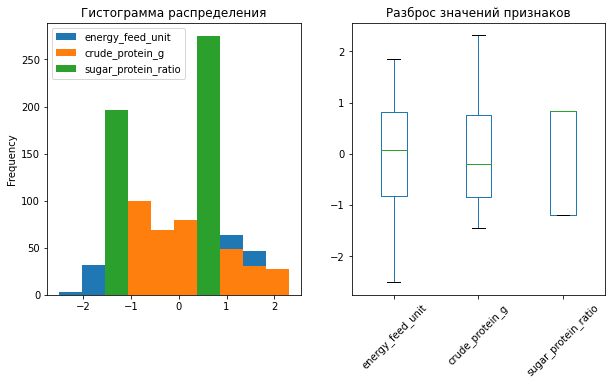

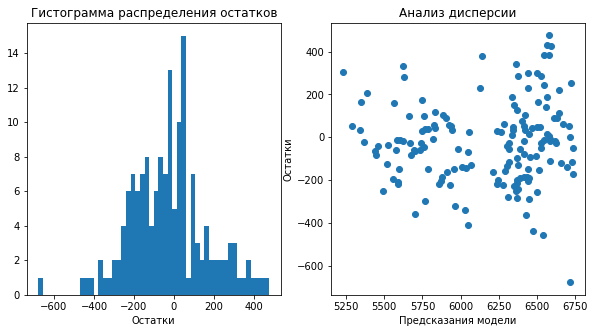

R^2 LinearRegression = 0.82 ((+∞ до 1), lim = 1) 
RMSE LinearRegression  = 192.43 ((0 до +∞), lim = 0)
MSE LinearRegression  = 37030.91 ((0 до +∞), lim = 0)
MAE LinearRegression = 149.04 ((0 до +∞), lim = 0)


In [74]:
X['sugar_protein_ratio'] = X['sugar_protein_ratio'].apply(lambda x: 1 if x>0.92 else 0)
X['energy_feed_unit'] = X['energy_feed_unit'].apply(lambda x: x**2)
# Разделение выборки на обучающую и целевую
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

# подготовка признаков (масштабирование и кодирование)
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# построение графиков по количественным признакам тренировочного датасета:
# гистограмму частотности распределения и ящик с усами.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box',   ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

# обучение модели и получение предсказаний на тестовых данных
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_test)

## проведение анализа остатков
# рассчет остатков
residuals = y_test - predictions

# построение графиков по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins = 50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

# рассчитаем значения R2 для линейной регрессии
r2 = r2_score(y_test, predictions)
print(f'R^2 LinearRegression = {r2:.2f} ((+∞ до 1), lim = 1) ')

# рассчитаем значения RMSE для линейной регрессии
rmse = (mean_squared_error(y_test, predictions))**0.5
print(f'RMSE LinearRegression  = {rmse:.2f} ((0 до +∞), lim = 0)')

# рассчитаем значения MSE для линейной регрессии
mse = mean_squared_error(y_test, predictions)
print(f'MSE LinearRegression  = {mse:.2f} ((0 до +∞), lim = 0)')

# посчитаем среднюю абсолютную ошибку на тестовых данных
mae = mean_absolute_error(y_test, predictions)
print(f'MAE LinearRegression = {mae:.2f} ((0 до +∞), lim = 0)')

1. Значение R^2 LinearRegression = 0,82 указывает на статистическую меру согласия - насколько модель линейной регрессии соответствует данным, на которых она построена - показыавет, насколько наша модель предсказывает лучше, чем если бы мы всегда предсказывали результат средним.
2. Гистограмма остатков все также приближается к нормальному закону распределения
3. Дисперсия остатков приближается к нормальному закону

### 5.3 Третья модель линейной регрессии

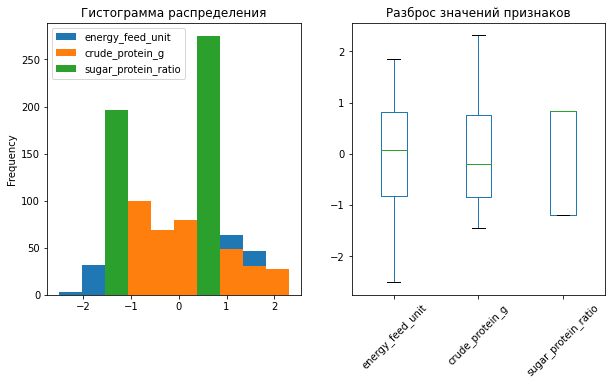

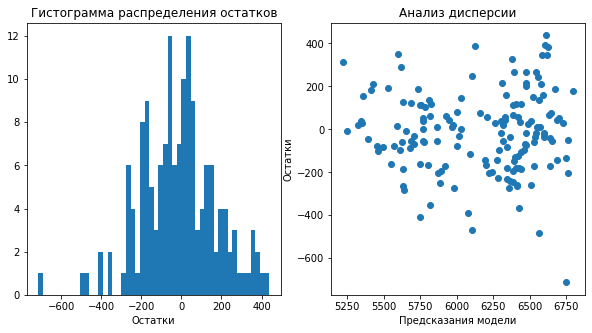

R^2 LinearRegression = 0.82 ((+∞ до 1), lim = 1) 
RMSE LinearRegression  = 188.88 ((0 до +∞), lim = 0)
MSE LinearRegression  = 35673.89 ((0 до +∞), lim = 0)
MAE LinearRegression = 146.16 ((0 до +∞), lim = 0)


In [75]:
cat_col_names = ['breed',
                 'pasture_type',
                 'sire_breed',
                 'age',
                 'dad_name'
                ]
num_col_names = ['energy_feed_unit',
                 'crude_protein_g',
                 'sugar_protein_ratio',
                ]

# Разделение выборки на обучающую и целевую
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

# подготовка признаков (масштабирование и кодирование)
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# построение графиков по количественным признакам тренировочного датасета:
# гистограмму частотности распределения и ящик с усами.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box',   ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

# обучение модели и получение предсказаний на тестовых данных
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_test)

## проведение анализа остатков
# рассчет остатков
residuals = y_test - predictions

# построение графиков по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins = 50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

# рассчитаем значения R2 для линейной регрессии
r2 = r2_score(y_test, predictions)
print(f'R^2 LinearRegression = {r2:.2f} ((+∞ до 1), lim = 1) ')

# рассчитаем значения RMSE для линейной регрессии
rmse = (mean_squared_error(y_test, predictions))**0.5
print(f'RMSE LinearRegression  = {rmse:.2f} ((0 до +∞), lim = 0)')

# рассчитаем значения MSE для линейной регрессии
mse = mean_squared_error(y_test, predictions)
print(f'MSE LinearRegression  = {mse:.2f} ((0 до +∞), lim = 0)')

# посчитаем среднюю абсолютную ошибку на тестовых данных
mae = mean_absolute_error(y_test, predictions)
print(f'MAE LinearRegression = {mae:.2f} ((0 до +∞), lim = 0)')

1. Значение R^2 LinearRegression = 0,82 увеличилось и указывает на статистическую меру согласия - насколько модель линейной регрессии соответствует данным, на которых она построена - показыавет, насколько наша модель предсказывает лучше, чем если бы мы всегда предсказывали результат средним.
2. Гистограмма астатков приближается к нормальному закону распределения, но её среднее значение немного смещено в лево. По отношению ко второй модели значения средней и медианы ошибки сместились правее, рагница из значений уменьшилась.

Сравнительный анализ указывает, что каждая последующая модель улучшалась. Самая лучшая модель третья с ней и будем работать при прогнозировании удойности буренок с "ЭкоФерма".

Расчитаем доверительный интервал прогноза второй модели

**Параметры соответствуют 2 модели.**

Расчитаем 95 % доверительный интервал модели

In [76]:
print('\n95% доверительный интервал =', stats.norm.interval
      (0.95,
       loc=np.mean(predictions), 
       scale=stats.sem(predictions)
      ),
      '\nон означает что:',
      '\n95% предсказанных значений удоев коров, будут лежать в указанном диапазоне'
     )


95% доверительный интервал = (6092.340075854288, 6221.3750700583805) 
он означает что: 
95% предсказанных значений удоев коров, будут лежать в указанном диапазоне


### 5.4 Спрогнозируем удой коров, которых фермер хочет купить

Добавим отсутствующие столбцы в `cow_buy`:
+ `ЭКЕ (Энергетическая кормовая единица)` = 'energy_feed_unit'
+ `Сырой протеин, г` = 'crude_protein_g'
+ `СПО (Сахаро-протеиновое соотношение)` = 'sugar_protein_ratio'

Возьмем среднее значение из `ferma_main` и увеличим на 5% 

In [77]:
ferma_main.head()

,id,yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,fat_percent,protein_percent,milk_flavor,age,dad_name
0,1,5863.0,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529.0,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810.0,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895.0,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302.0,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин


In [78]:
X_g = cow_buy
# Добавление столбцов со средними значениями из ferma_main + 5%
X_g['energy_feed_unit'] = ferma_main['energy_feed_unit'].mean()*1.05
X_g['crude_protein_g'] = (ferma_main['crude_protein_g'].mean()*1.05).astype(int)
X_g['sugar_protein_ratio'] = ferma_main['sugar_protein_ratio'].mean()*1.05
# Приведение колонок в соответствие
columns = ferma_main.columns
columns = columns.drop(labels=['id','yield_kg',  'milk_flavor'])
X_g = X_g[columns]
# Удаление излишних данных не влияющих на удой
X_g = X_g.drop(['fat_percent', 'protein_percent'], axis=1)
# Преобразование столбцов к требованиям 2 модели
X_g['sugar_protein_ratio'] = X_g['sugar_protein_ratio'].apply(lambda x: 1 if x>0.92 else 0)
X_g['energy_feed_unit'] = X_g['energy_feed_unit'].apply(lambda x: x**2)
X_g

,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,age,dad_name
0,233.361138,2019,1,Вис Бик Айдиал,Холмистое,Айдиал,более_2_лет,Геркулес
1,233.361138,2019,1,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,Буйный
2,233.361138,2019,1,РефлешнСоверинг,Равнинное,Соверин,более_2_лет,Барин
3,233.361138,2019,1,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет,Буйный
4,233.361138,2019,1,РефлешнСоверинг,Равнинное,Айдиал,более_2_лет,Буйный
5,233.361138,2019,1,РефлешнСоверинг,Равнинное,Соверин,менее_2_лет,Геркулес
6,233.361138,2019,1,Вис Бик Айдиал,Холмистое,Айдиал,более_2_лет,Геркулес
7,233.361138,2019,1,Вис Бик Айдиал,Равнинное,Соверин,более_2_лет,Буйный
8,233.361138,2019,1,РефлешнСоверинг,Равнинное,Соверин,более_2_лет,Барин
9,233.361138,2019,1,РефлешнСоверинг,Холмистое,Айдиал,менее_2_лет,Буйный


In [79]:
X.head()

,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,age,dad_name
0,201.64,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет,Буйный
1,163.84,2138,0,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,Соловчик
2,196.00,1854,0,РефлешнСоверинг,Холмистое,Соверин,более_2_лет,Барин
3,153.76,2012,0,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет,Буйный
4,163.84,1675,0,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,Барин


In [80]:
# подготовка признаков (масштабирование и кодирование)
X_g_ohe = encoder.transform(X_g[cat_col_names])
X_g_scaled = scaler.transform(X_g[num_col_names])
X_g_ohe = pd.DataFrame(X_g_ohe, columns=encoder_col_names)
X_g_scaled = pd.DataFrame(X_g_scaled, columns=num_col_names)
X_g = pd.concat([X_g_ohe, X_g_scaled], axis=1)

# предсказание на данных
predictions = model_lr.predict(X_g)

# Таблица для покупок
buy = cow_buy.copy()
buy['predictions_yield_kg'] = predictions.astype(int)

In [81]:
print('Модель предлагает купить', len(buy[buy['predictions_yield_kg']>6000]), 'коров из', len(cow_buy), 'предлагаемых "ЭкоФермой"')
print('Список коров "Экофермы" и ожидаемые удои в таблице ниже:')
buy

Модель предлагает купить 20 коров из 20 предлагаемых "ЭкоФермой"
Список коров "Экофермы" и ожидаемые удои в таблице ниже:


,breed,pasture_type,sire_breed,dad_name,fat_percent,protein_percent,age,energy_feed_unit,crude_protein_g,sugar_protein_ratio,predictions_yield_kg
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019,0.958744,6609
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019,0.958744,6378
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019,0.958744,6283
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019,0.958744,6592
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019,0.958744,6541
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019,0.958744,6425
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019,0.958744,6609
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,2019,0.958744,6570
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019,0.958744,6283
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019,0.958744,6400


С учетом представленных данных "ЭкоФермой" и с учетом пересмотра подхода к кормлению (увеличение ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г, СПО (Сахаро-протеиновое соотношение) на 5 % для новых коров) модель спрогнозировала, что все коровы из 20 предложенных и указанных в таблице `buy` будут давать молока больше 6000 кг. в год.

## 6. Обучение модели логистической регрессии

### 6.1 Подготовка данных

In [82]:
RANDOM_STATE = 42

cat_col_names = ['breed',
                 'pasture_type',
                 'sire_breed',
                 'age',
                 'dad_name']
num_col_names = ['energy_feed_unit',
                 'crude_protein_g',
                 'sugar_protein_ratio',
                 'fat_percent',
                 'protein_percent'
                ]
# Отделение целевого признака
X = ferma_main.drop('milk_flavor', axis=1)
y = ferma_main['milk_flavor']
X_g = buy
# перевод в числовой признак Вкусно = 1, Не вкусно = 0
y = y.apply(lambda x: 0 if x=='не вкусно' else 1)

# Удаление излишних данных не влияющих на удой
X = X.drop(['id','yield_kg'], axis=1)
# Перестановка столбцов
columns = X.columns
X_g = X_g[columns]
# Преобразование столбцов
X['sugar_protein_ratio'] = X['sugar_protein_ratio'].apply(lambda x: 1 if x>0.92 else 0)
X['energy_feed_unit'] = X['energy_feed_unit'].apply(lambda x: x**2)
X_g['sugar_protein_ratio'] = X_g['sugar_protein_ratio'].apply(lambda x: 1 if x>0.92 else 0)
X_g['energy_feed_unit'] = X_g['energy_feed_unit'].apply(lambda x: x**2)
# Приведение типов
X_g[['yield_kg', 'crude_protein_g']] = ferma_main[['yield_kg', 'crude_protein_g']].astype('int')

# Проверка на совпадение и разницу в названияж столбцов
X_cols = X.columns
X_g_cols = X_g.columns
common_cols = X_cols.intersection(X_g_cols)
train_not_test = X_cols.difference(X_g_cols)
print('Совпадающие столбцы', common_cols)
print('Разные столбцы', train_not_test)

Совпадающие столбцы Index(['energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'breed',
       'pasture_type', 'sire_breed', 'fat_percent', 'protein_percent', 'age',
       'dad_name'],
      dtype='object')
Разные столбцы Index([], dtype='object')


/tmp/ipykernel_48/4221511526.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_g['sugar_protein_ratio'] = X_g['sugar_protein_ratio'].apply(lambda x: 1 if x>0.92 else 0)
/tmp/ipykernel_48/4221511526.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_g['energy_feed_unit'] = X_g['energy_feed_unit'].apply(lambda x: x**2)


In [83]:
X_train, X_test, y_train, y_test = train_test_split(
X,
y,
random_state=RANDOM_STATE
)

# подготовка признаков (масштабирование и кодирование)
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# Обучение модели
clf = LogisticRegression(random_state=RANDOM_STATE)
clf = clf.fit(X_train, y_train)
# Получение предсказания
y_pred = clf.predict(X_test)

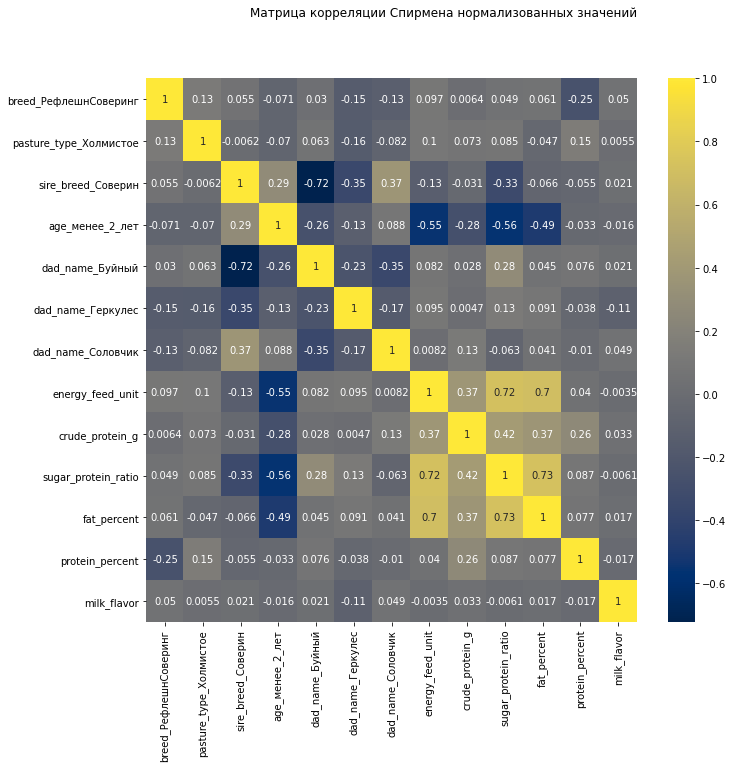

In [84]:
# Построим матрицу корреляций
x_corr = X_train
x_corr['milk_flavor'] = y_train
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции Спирмена нормализованных значений')
sns.heatmap(x_corr.corr(method="spearman"), annot=True, cmap='cividis');

Вкус молока должен зависеть от его жирности и протеинового содержания в нем, возможно от породы коров и типа выпаса.
Одним из условий правильной классификации является наличие линейной зависимости между входными и прогнозными значениями.
В нашем случае такой зависимости нет, а следовательно построить рабочую модель основанную на логистической функции не представится возможым. 
Скорее всего это произошло потому что, у каждого человека вкусы разные и фермер включил в таблицу свое субьективное мнение, при этом его мнение никак не соотностися с данными.

Посмотрим на результаты работы модели

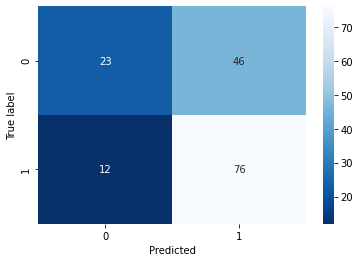

In [85]:
# матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

In [86]:
# Расчет показателей
acc = accuracy_score(y_test, y_pred)
print('accuracy: ',round(acc,3), '(Доля правильных ответов)')

recall = recall_score(y_test, y_pred)
print('recall: ',round(recall ,3), '(Ошибка FN (False Negative))')

precision = precision_score(y_test, y_pred) 
print('precision: ',round(precision,3), '(Ошибка FP (False Positive))')

accuracy:  0.631 (Доля правильных ответов)
recall:  0.864 (Ошибка FN (False Negative))
precision:  0.623 (Ошибка FP (False Positive))


### 6.2 Анализ модели логистической регресии

Молоко вкусное это признак 1 а следовательно:
1. Ошибка FN (False Negative) - (Recall). Модель ошибается и указывает на то что молоко невкусное, хотя это не так - в нашем случае это даже хорошо.
2. Ошибка FP (False Positive) - (Precision). Модель ошибается и указывает на то, что молоко вкусное, хотя это не так - в нашем случае это плохо, значит необходимо минимизировать её.


 Функция расчета предсказаний с учетом изменяемого порога\
 Использование функции predict_proba взамен predict

In [87]:
def custom_predict(X, threshold):
    probs = clf.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int), probs[:, 1]


Создание Dataframe со значениями порога ('thresholds') от 0.01 до 0.99 с шагом 0.01
и значениями 'acc', 'recall', 'precision', 'tn', 'fp', 'fn', 'tp'

In [88]:
thresholds = [i/100 for i in range(1,100)]

acc = []
recall = []
precision = []
tn = []
fp = []
fn = []
tp = []
# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    new_preds = custom_predict(X=X_test, threshold=threshold)[0]
    # Расчет показателей 'accuracy: ',round(acc,3), '(Доля правильных ответов)'
    acc.append(accuracy_score(y_test, new_preds))
    # Расчет показателей 'recall: ',round(recall ,3), '(Ошибка FN (False Negative))'
    recall.append(recall_score(y_test, new_preds))
    # Расчет показателей 'precision: ',round(precision,3), '(Ошибка FP (False Positive))'
    precision.append(precision_score(y_test, new_preds, zero_division=0))
    # Расчет количества ошибок по типам
    tn.append(np.sum((new_preds == 0) & (y_test == 0)))
    fp.append(np.sum((new_preds == 1) & (y_test == 0)))
    fn.append(np.sum((new_preds == 0) & (y_test == 1)))
    tp.append(np.sum((new_preds == 1) & (y_test == 1)))
    
acc, recall, precision
df = pd.DataFrame([thresholds, acc, recall, precision, tn, fp, fn, tp]).T
df.columns = ['thresholds', 'acc', 'recall', 'precision', 'tn', 'fp', 'fn', 'tp']
df[47:52]

,thresholds,acc,recall,precision,tn,fp,fn,tp
47,0.48,0.624204,0.875000,0.616000,21.0,48.0,11.0,77.0
48,0.49,0.636943,0.875000,0.626016,23.0,46.0,11.0,77.0
49,0.50,0.630573,0.863636,0.622951,23.0,46.0,12.0,76.0
50,0.51,0.630573,0.852273,0.625000,24.0,45.0,13.0,75.0
51,0.52,0.636943,0.852273,0.630252,25.0,44.0,13.0,75.0


Поиск порогового значения `thresholds` для минимизации ошибки FP (False Positive), а это значит не устранить её полностью, а минимизировать. Это значит, что  при выборе порога отношения к классам может остаться минимальное количество ошибок `FP`.

In [89]:
thresholds_precision = df[df['fp']==0].head(1)['thresholds'].values[0]

print('Манимизация ошибки FP (False Positive)  при threshold =', thresholds_precision) 
print('\nЗначения показателей при пороге = ', thresholds_precision, 'в таблице ниже')
df[df['thresholds']==thresholds_precision]


Манимизация ошибки FP (False Positive)  при threshold = 0.81

Значения показателей при пороге =  0.81 в таблице ниже


,thresholds,acc,recall,precision,tn,fp,fn,tp
80,0.81,0.484076,0.079545,1.0,69.0,0.0,81.0,7.0


**Вывод по анализу модели**

1. При покупке коров критичнее всего ошибка первого рода -  Ошибка FP (False Positive) - (Precision). Модель ошибается и указывает на то, что молоко вкусное, хотя это не так - в нашем случае это плохо, значит необходимо минимизировать её.
2. При минимизации указанной ошибки подобран порог принадлежности к классам = 0.80 при этом значение важных метрик составило АСС = 0.496 (уменьшилось с 0.63), Recall = 0.113 (уменьшилось с 0.86), Precision = 0.909 (увеличилось с 0.62)
3. Такой высокий порог в 0.81 в нашей модели неоправдан, так как вкус молока несильно влияет на продажу, ведь по итогу на всех фермах молоко всегда смешивается, а затем сепарируется.

**Резюмируя**
Из за отсутствия линейной связи между входными данными и целевыми (вкус молока) при минимизации ошибки FP (False Positive) - (Precision) подобран очень большой порог принадлежности к классам. 

### 6.3 Прогноз вкуса молока коров

Подготовка признаков (масштабирование и кодирование) данных для прогноза

In [90]:
X_g_ohe = encoder.transform(X_g[cat_col_names])
X_g_scaled = scaler.transform(X_g[num_col_names])
X_g_ohe = pd.DataFrame(X_g_ohe, columns=encoder_col_names)
X_g_scaled = pd.DataFrame(X_g_scaled, columns=num_col_names)
X_g = pd.concat([X_g_ohe, X_g_scaled], axis=1)

Ппредсказание на данных с выбранным порогом

In [91]:
predictions_precision = custom_predict(X=X_g, threshold=thresholds_precision)
predictions_precision

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0.64940781, 0.68061783, 0.52684743, 0.35787469, 0.47249384,
        0.08435407, 0.65993771, 0.60973938, 0.54198381, 0.69483906,
        0.12343063, 0.58552164, 0.11790391, 0.59747943, 0.50667261,
        0.39408938, 0.6599703 , 0.11288459, 0.35578468, 0.53159881]))

In [92]:
buy['milk_flavor_precision'] = predictions_precision[0]
buy['probability'] = predictions_precision[1]
print('Модель предлагает купить', len(buy[buy['milk_flavor_precision']==1]), 'из', len(cow_buy), 'предлагаемых "ЭкоФермой" по вкусности молока')

Модель предлагает купить 0 из 20 предлагаемых "ЭкоФермой" по вкусности молока


**Вывод по прогнозу модели:**
+ Мнимизация ошибки FP (False Positive) - (Precision) в нашем случае целесообразна - "Модель ошибается и указывает на то, что молоко вкусное, хотя это не так - в нашем случае это плохо, значит необходимо минимизировать её. + Подобран порог принадлежности к классам = 0.80 при этом значение важных метрик составило АСС = 0.496 (уменьшилось с 0.63), Recall = 0.113 (уменьшилось с 0.86), Precision = 0.909 (увеличилось с 0.62)
+ Такой высокий порог в 0.80 в нашей модели неоправдан, так как вкус молока несильно влияет на продажу, ведь по итогу на всех фермах молоко всегда смешивается, а затем сепарируется. 
+ Минимизация привела к тому, что модель не рекомендует покупать коров в "ЭкоФерме".

## Итоговые выводы

### 7.1 Добавим прогнозы вкуса молока и удоя коров в датафрейм с коровами "ЭкоФерма"

Добавим прогнозы вкуса молока и удоя коров в датафрейм с коровами `cow_buy`, покупку которых рассматривает фермер. При этом в столбце `milk_flavor_precision` и `milk_flavor_recommended` обозначено `0` - невкусное молоко, `1` - вкусное молоко 

In [93]:
cow_buy['forecast_yield_kg'] = ferma_main['yield_kg']
cow_buy['milk_flavor_precision'] = buy['milk_flavor_precision']
cow_buy['probability'] = buy['probability'].round(2)
cow_buy

,breed,pasture_type,sire_breed,dad_name,fat_percent,protein_percent,age,energy_feed_unit,crude_protein_g,sugar_protein_ratio,forecast_yield_kg,milk_flavor_precision,probability
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019,0.958744,5863.0,0,0.65
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019,0.958744,5529.0,0,0.68
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019,0.958744,5810.0,0,0.53
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019,0.958744,5895.0,0,0.36
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019,0.958744,5302.0,0,0.47
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019,0.958744,5254.0,0,0.08
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019,0.958744,5910.0,0,0.66
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,2019,0.958744,6179.0,0,0.61
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019,0.958744,6783.0,0,0.54
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019,0.958744,5339.0,0,0.69


### 7.2 Отберем коров, для которых спрогнозирован удой более 6000 кг. в год и вкусное молоко.

In [94]:
print('Модель предлагает купить', len(cow_buy.query('forecast_yield_kg > 6000 and milk_flavor_precision == 1')), 'из', len(cow_buy), 'предлагаемых "ЭкоФермой" по вкусности молока  и годовому удою больше 6000 кг.:')
cow_buy.query('forecast_yield_kg > 6000 and milk_flavor_precision == 1'); 

Модель предлагает купить 0 из 20 предлагаемых "ЭкоФермой" по вкусности молока  и годовому удою больше 6000 кг.:


### 7.3 Результаты работы моделей для фермера

1. В процессе работы 
+ Спрогнозированы удои новых коров из "ЭкоФермы". Коров с удоем более 6000 килограммов в год оказалось 20 из 20.
+ При минимизации ошибки FP (False Positive) - (Precision) модель по вкусности молока предлагает вообще не покупать коров. 

Учитывая вышеизложенное фермер с минимальным риском для себя, по вкусу молока, не может купить ни одной коровы столбец `milk_flavor_precision` в таблице `cow_buy`. В связи с тем, что проведена минимизация ошибки первого рода FP (False Positive).
+ Рекомендуется:
    + В ближайщее время переоценить молоко на вкусность (сделать это коллегиально, или провести опрос потребителей, желательно с привязкой к его жирности и белку), и с новыми данными мы построим обновленную  модель.
    + Фермеру разьяснить порядок работы модели и в беседе уточнить критерии  установки требований к параметру разделения на классы.

### 7.4 О моделях работы линейной и логистической регрессии.

В процессе работы были построены прогнозные модели линейной и логической регресии.
+ Модель линейной регрессии показала хорошие результаты. По ней построен прогноз удойности коров. Модель передлагает приобрести 0 предложенных коров из 20 представленных:
    + Использованы следующие способы улучшения:
    1. Категориальный признак СПО в `sugar_protein_ratio` в бинарный признак с явной границей в 0.92 едениц.
    2. Категориальный признак ЭКЕ в `energy_feed_unit` для учета изгиба данных возведем в квадрат.
    + Задачу мы пытались решить линейной регрессией которая не учитывает нелинейную зависимость между данными, это сделаем в следующий раз, когда изучим. Хочется сказать, что предела совершенства нет. Нет ограничения и в нашем случае. Чем больше статистики тем лучше, на больших данных могут возникнуть линейные зависимости о которых мы даже и не предполагаем, но их можно заметить при анализе.
    + При применении линейной регресии очень важны следующие метрики:
    1. R^2 LinearRegression ((+∞ до 1), lim = 1) В нашем случае = 0.82  указывает на статистическую меру согласия - насколько модель линейной регрессии соответствует данным, на которых она построена - показыавет, насколько наша модель предсказывает лучше, чем если бы мы всегда предсказывали результат средним.
    2. RMSE LinearRegression   ((0 до +∞), lim = 0) В нашем случае = 188.88 и измеряет степень ошибки модели при прогнозировании количественных данных.
    3. MSE (Среднеквадратичная ошибка) LinearRegression   ((0 до +∞), lim = 0) В нашем случае = 35673.89 и применяется в случаях, когда требуется подчеркнуть большие ошибки и выбрать модель, которая дает меньше именно больших ошибок.
    4. MAE LinearRegression  ((0 до +∞), lim = 0) В нашем случае = 146.16 и указывает на то, насколько прогнозы в среднем близки к реальной модели.

+ Модель логической регрессии показала неочень хорошие результаты, так как в данных отсутствует линейная зависимость между входными и целевыми данными. В прогнозной модели сведена ошибка '(Ошибка FP (False Positive))' к минимуму   (прогноз что, молоко вкусное, хотя это не так - в нашем случае это плохо).
    + При применении логической регресии очень важны следующие метрики:
    1. Вероятность предсказания модели АСС - указывает на вероятность совпадения прогноза с истинным значением (чем больше тем лучше)
    2. Ошибка FN (False Negative) - (Recall). В нашем случае это когда модель ошибается и указывает на то что молоко невкусное, хотя это не так - в нашем случае это даже хорошо.
    3. Ошибка FP (False Positive) - (Precision). В нашем случае это когда модель ошибается и указывает на то, что молоко вкусное, хотя это не так - в нашем случае это плохо, значит необходимо минимизировать её.
    
Нет предела совершенства. Модель можно и нужно совершенствовать введением новых параметров, набором дополнительной статистики, разделением данных на кластеры, проведением большого количества итераций и сопоставлений, использовать другие не линейные алгоритмы прогнозирования.   
    
**Резюмируя**

+ В соотвветствии с поставленной задачей и представленным данным. Фермер без риска для себя, по удою молока, может купить любую корову из предложенного списка, столбец `forecast_yield_kg`, по вкусу молока, не может купить ни одной коровы, столбец `milk_flavor_precision`.
+ Рекомендуется в ближайщее время переоценить молоко на вкусность (сделать это коллегиально, или провести опрос потребителей, желательно с привязкой к его жирности и белку), и с новыми данными мы построим обновленную  модель.
+ Рекомендуется в ближайщее провести беседу с фермером, разьяснить что такое ошибки первого и второго рода и выбрать допустимый критерии  разделения на классы, для внесения их в модель логической регрессии.